In [1]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn
import cv2 as cv
import nibabel as nib
import pickle
import glob
import imgaug as ia
import imgaug.augmenters as iaa
import tqdm
import gc, os
import warnings
import tensorflow as tf
from keras import backend as K
from keras import losses, metrics
from keras import optimizers
from keras import callbacks
from keras.models import Model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers import concatenate, Conv2D, MaxPooling2D, Conv2DTranspose
from keras.layers import Multiply
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from skimage import morphology
from skimage import measure
#import keras_segmentation as ks

warnings.filterwarnings('ignore')
%matplotlib inline
print("Version: ", tf.version.VERSION)
print("GPU is", "available" if tf.config.experimental.list_physical_devices("GPU") else "not available")

Version:  2.2.0
GPU is available


## 1. Loading data

In [2]:
with open('../outputs/cropped_data.cp', 'rb') as myfile:
    data = pickle.load(myfile)

with tf.device('/cpu:0') :
    ccts = tf.cast(data['ccts'], dtype=tf.float64)
    clungs = tf.cast(data['clungs'], dtype=tf.double)
    cinfects = tf.cast(data['cinfects'], dtype=tf.double)

print(ccts.shape, clungs.shape, cinfects.shape)

(4042, 128, 128, 1) (4042, 128, 128, 1) (4042, 128, 128, 1)


**Just overlaying infection masks over the corresponding CT scans**

In [3]:
def plot_cts_infects(ct, lung, infect, axes) :

    axes[0].imshow(ct[:,:,0], cmap='bone')
    axes[0].set_title('CT image')

    axes[1].imshow(ct[:,:,0], cmap='bone')
    axes[1].imshow(lung[:,:,0], alpha=0.5, cmap='Greens')
    axes[1].imshow(infect[:,:,0], alpha=0.5, cmap='Reds')
    axes[1].set_title('Infection')

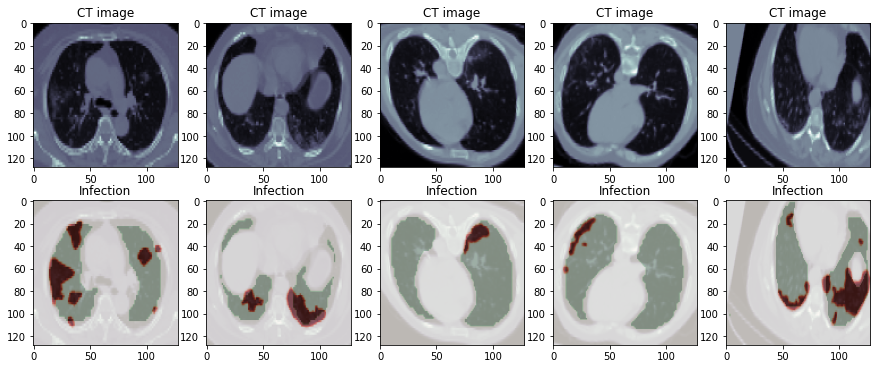

In [10]:
fig, axes = plt.subplots(2, 5, figsize=(15,6))

for ii, idx in enumerate(range(280, 400, 25)) :
    with tf.device('/cpu:0') :
        plot_cts_infects(ccts[idx], clungs[idx], cinfects[idx], list(axes[:,ii]))

# 2. Defining evaluation metrics

The most commonly used metrics for image segmentation are the IoU and the Dice Coefficient. The Dice Coefficient is 2 times the Area of overlap divided by the total number of pixels in both images (true and predicted). The Dice coefficient is very similar to the IoU, and they both range from 0 to 1, with 1 signifying the greatest similarity between predicted and truth.

See https://github.com/keras-team/keras/issues/9395


In [4]:
def dice(y_true, y_pred, smooth=1):
    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
    dice = K.mean((2. * intersection + smooth)/(union + smooth), axis=0)
    return dice

def dice_loss(y_true, y_pred):
    loss = 1 - dice(y_true, y_pred)
    return loss

def bce_dice_loss(y_true, y_pred): #Binary Cross-Entropy
    loss = 0.5*losses.binary_crossentropy(y_true, y_pred) + 0.5*dice_loss(y_true, y_pred)
    return loss

def tversky_loss(y_true, y_pred):
    alpha, beta  = 0.5, 0.5
    ones = K.ones(K.shape(y_true))
    p0 = y_pred
    p1 = ones-y_pred
    g0 = y_true
    g1 = ones-y_true
    num = K.sum(p0*g0, (0,1,2))
    den = num + alpha*K.sum(p0*g1,(0,1,2)) + beta*K.sum(p1*g0,(0,1,2))
    T = K.sum(num/den) 
    Ncl = K.cast(K.shape(y_true)[-1], 'float32')
    return Ncl-T

def weighted_bce_loss(y_true, y_pred, weight):
    epsilon = 1e-7
    y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
    logit_y_pred = K.log(y_pred / (1. - y_pred))
    loss = weight * (logit_y_pred * (1. - y_true) + 
                     K.log(1. + K.exp(-K.abs(logit_y_pred))) + 
                     K.maximum(-logit_y_pred, 0.))
    return K.sum(loss) / K.sum(weight)

def weighted_dice_loss(y_true, y_pred, weight):
    smooth = 1.
    w, m1, m2 = weight, y_true, y_pred
    intersection = (m1*m2)
    score = (2.*K.sum(w*intersection) + smooth) / (K.sum(w*m1) + K.sum(w*m2) + smooth)
    loss = 1. - K.sum(score)
    return loss

def weighted_bce_dice_loss(y_true, y_pred):
    y_true = K.cast(y_true, 'float32')
    y_pred = K.cast(y_pred, 'float32')
    averaged_mask = K.pool2d(y_true, pool_size=(50, 50), strides=(1, 1), 
                             padding='same', pool_mode='avg')
    weight = K.ones_like(averaged_mask)
    w0 = K.sum(weight)
    weight = 5. * K.exp(-5.*K.abs(averaged_mask - 0.5))
    w1 = K.sum(weight)
    weight *= (w0 / w1)
    loss = 0.5*weighted_bce_loss(y_true, y_pred, weight) + 0.5*dice_loss(y_true, y_pred)
    return loss

# 3. Cosine Annealing Learning Rate

An effective snapshot ensemble requires training a neural network with an aggressive learning rate schedule.

The cosine annealing schedule is an example of an aggressive learning rate schedule where learning rate starts high and is dropped relatively rapidly to a minimum value near zero before being increased again to the maximum.

We can implement the schedule as described in the 2017 paper “Snapshot Ensembles: Train 1, get M for free.” The equation requires the total training epochs, maximum learning rate, and number of cycles as arguments as well as the current epoch number. The function then returns the learning rate for the given epoch.

See https://machinelearningmastery.com/snapshot-ensemble-deep-learning-neural-network/

In [5]:
# define custom learning rate schedule
class CosineAnnealingLearningRateSchedule(callbacks.Callback):
    # constructor
    def __init__(self, n_epochs, n_cycles, lrate_max, verbose=0):
        self.epochs = n_epochs
        self.cycles = n_cycles
        self.lr_max = lrate_max
        self.lrates = list()
 
    # calculate learning rate for an epoch
    def cosine_annealing(self, epoch, n_epochs, n_cycles, lrate_max):
        epochs_per_cycle = np.floor(n_epochs/n_cycles)
        cos_inner = (np.pi * (epoch % epochs_per_cycle)) / (epochs_per_cycle)
        return lrate_max/2 * (np.cos(cos_inner) + 1)
 
    # calculate and set learning rate at the start of the epoch
    def on_epoch_begin(self, epoch, logs=None):
        # calculate learning rate
        lr = self.cosine_annealing(epoch, self.epochs, self.cycles, self.lr_max)
        # set learning rate
        K.set_value(self.model.optimizer.lr, lr)
        # log value
        self.lrates.append(lr)

* All the hyperparameters are put in place after repeating trial and error for a fixed number of epochs.

# 4. Split data into train and validation sets

In [6]:
train_size = int(0.9*ccts.shape[0])

with tf.device('/cpu:0') :
    X_train, yi_train = (ccts[:train_size]/255, 
                         cinfects[:train_size])

    X_valid, yi_valid = (ccts[train_size:]/255, 
                         cinfects[train_size:])

print(X_train.shape, yi_train.shape)
print(X_valid.shape, yi_valid.shape)

(3637, 128, 128, 1) (3637, 128, 128, 1)
(405, 128, 128, 1) (405, 128, 128, 1)


# 5. Convolutional Neural Network

#### Model building blocks

These two downsample images and have the option to be trainable or not.

In [7]:
def downsampling_block_1 (x_in, conv2Dfilters, maxpool2Dsize=(2,2), trainable=True) :
    x = Conv2D(conv2Dfilters, (3,3), activation='relu', padding='same', 
               kernel_initializer="he_normal", trainable=trainable) (x_in)
    x = Conv2D(conv2Dfilters, (3, 3), activation='relu', padding='same', 
               kernel_initializer="he_normal", trainable=trainable) (x)
    x_inter = BatchNormalization(trainable=trainable) (x)
    x = MaxPooling2D(maxpool2Dsize) (x_inter) 
    x = Dropout(0.2)(x) 
    
    return x, x_inter

def downsampling_block_2 (x_in, conv2Dfilters, trainable=True) :
    x = BatchNormalization(trainable=trainable) (x_in)
    x = Conv2D(conv2Dfilters, (3, 3), activation='relu', padding='same', 
               kernel_initializer="he_normal", trainable=trainable) (x)
    x = Conv2D(conv2Dfilters, (3, 3), activation='relu', padding='same', 
               kernel_initializer="he_normal", trainable=trainable) (x) 
    
    return x

Our model consists of one single input (CT images) and two outputs (lung and infection masks). To efficently train the model, we can start training the first stage that generates lung masks by setting `trainable=False` in the infection stage. Then, train the second stage only by fixing the first stage, and finally train the whole network.

In [8]:
## Note: dimensions are listed for a 100x100 input images
def single_stage_seg(x_input, num_filters, trainable=True) :
    
    x, x1 = downsampling_block_1 (x_input, num_filters[0], maxpool2Dsize=(2,2), trainable=trainable) #x: 50x50
    x, x2 = downsampling_block_1 (x, num_filters[1], maxpool2Dsize=(2,2), trainable=trainable) #x: 25x25
    x, _ = downsampling_block_1 (x, num_filters[2], maxpool2Dsize=(1,1), trainable=trainable) #x: 25x25
    x, _ = downsampling_block_1 (x, num_filters[3], maxpool2Dsize=(1,1), trainable=trainable) #x: 25x25

    x = downsampling_block_2 (x, num_filters[3], trainable=trainable) #x: 25x25
    
    x = Conv2DTranspose(num_filters[2], (2, 2), strides=(2,2), padding='same', trainable=trainable) (x) #x: 50x50
    x = downsampling_block_2 (x, num_filters[2], trainable=trainable) #x: 50x50

    x = Conv2DTranspose(num_filters[1], (2, 2), padding='same', trainable=trainable) (x) #x: 50x50
    x = concatenate([x, x2]) #x: 50x50
    x = downsampling_block_2 (x, num_filters[1], trainable=trainable) #x: 50x50

    x = Conv2DTranspose(num_filters[0], (2, 2), strides=(2,2), padding='same', trainable=trainable) (x) #x: 100x100
    x = concatenate([x, x1], axis=3) #x: 100x100
    x = downsampling_block_2 (x, num_filters[0], trainable=trainable) #x: 100x100
    
    return x

In [9]:
def infect_seg(input_shape, num_filters=[32,64,64,128]) :
    
    x_input = Input(input_shape)
    
    ###  INFECTION SEGMENTATION
    x = single_stage_seg(x_input, num_filters, trainable=True)
    
    infect_seg = Conv2D(1, (1, 1), activation='sigmoid', 
                          name='lung_output', trainable=True)(x) # identifying lungs

    model = Model(inputs=x_input, outputs=infect_seg, name='infect_seg')
    
    return model

strategy = tf.distribute.MirroredStrategy()
print('Number of devices {}'.format(strategy.num_replicas_in_sync))

with strategy.scope() :
    infect_seg = infect_seg(ccts.shape[1:])

infect_seg.summary()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Number of devices 1
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localho

# 6. Training

In [10]:
# define learning rate callback
epochs = 200
lrmax = 5e-5
n_cycles = epochs / 25
lr_cb = CosineAnnealingLearningRateSchedule(epochs, n_cycles, lrmax)

checkpoint_fpath = "../outputs/weights_infectseg.hdf5"
cts_checkpoint_cb = callbacks.ModelCheckpoint(checkpoint_fpath, 
                                              monitor='val_dice', 
                                              save_best_only=True, 
                                              mode='max', 
                                              verbose=1,
                                              save_weights_only=True)

batch_size = 8
optim = optimizers.Adam(lr=5e-5, beta_1=0.9, beta_2=0.99)
with strategy.scope() :
    infect_seg.compile(optimizer=optim, loss=bce_dice_loss, metrics=[dice])

In [11]:
infect_seg_res = infect_seg.fit(x = X_train, 
                                y = yi_train,
                                batch_size = batch_size, 
                                epochs = epochs,
                                verbose = 1,
                                validation_data = (X_valid, yi_valid),
                                callbacks = [cts_checkpoint_cb, lr_cb])

Epoch 1/200
455/455 [==============================] - ETA: 0s - dice: 0.1681 - loss: 0.5407
Epoch 00001: val_dice improved from -inf to 0.36306, saving model to ../outputs/weights_infect_seg-githubi.hdf5
455/455 [==============================] - 100s 219ms/step - dice: 0.1681 - loss: 0.5407 - val_dice: 0.3631 - val_loss: 0.3572
Epoch 2/200
455/455 [==============================] - ETA: 0s - dice: 0.4107 - loss: 0.3389
Epoch 00002: val_dice improved from 0.36306 to 0.49456, saving model to ../outputs/weights_infect_seg-githubi.hdf5
455/455 [==============================] - 40s 89ms/step - dice: 0.4107 - loss: 0.3389 - val_dice: 0.4946 - val_loss: 0.3049
Epoch 3/200
455/455 [==============================] - ETA: 0s - dice: 0.5090 - loss: 0.3039
Epoch 00003: val_dice improved from 0.49456 to 0.55614, saving model to ../outputs/weights_infect_seg-githubi.hdf5
455/455 [==============================] - 40s 89ms/step - dice: 0.5090 - loss: 0.3039 - val_dice: 0.5561 - val_loss: 0.2772
Ep

Epoch 29/200
455/455 [==============================] - ETA: 0s - dice: 0.6516 - loss: 0.2199
Epoch 00029: val_dice improved from 0.64971 to 0.65488, saving model to ../outputs/weights_infect_seg-githubi.hdf5
455/455 [==============================] - 40s 89ms/step - dice: 0.6516 - loss: 0.2199 - val_dice: 0.6549 - val_loss: 0.2097
Epoch 30/200
455/455 [==============================] - ETA: 0s - dice: 0.6560 - loss: 0.2158
Epoch 00030: val_dice did not improve from 0.65488
455/455 [==============================] - 40s 89ms/step - dice: 0.6560 - loss: 0.2158 - val_dice: 0.6100 - val_loss: 0.2360
Epoch 31/200
455/455 [==============================] - ETA: 0s - dice: 0.6507 - loss: 0.2187
Epoch 00031: val_dice did not improve from 0.65488
455/455 [==============================] - 40s 88ms/step - dice: 0.6507 - loss: 0.2187 - val_dice: 0.6527 - val_loss: 0.2111
Epoch 32/200
455/455 [==============================] - ETA: 0s - dice: 0.6615 - loss: 0.2118
Epoch 00032: val_dice did not im

455/455 [==============================] - ETA: 0s - dice: 0.6888 - loss: 0.1932
Epoch 00056: val_dice did not improve from 0.70804
455/455 [==============================] - 40s 88ms/step - dice: 0.6888 - loss: 0.1932 - val_dice: 0.6830 - val_loss: 0.1913
Epoch 57/200
455/455 [==============================] - ETA: 0s - dice: 0.6952 - loss: 0.1906
Epoch 00057: val_dice did not improve from 0.70804
455/455 [==============================] - 40s 89ms/step - dice: 0.6952 - loss: 0.1906 - val_dice: 0.7037 - val_loss: 0.1833
Epoch 58/200
455/455 [==============================] - ETA: 0s - dice: 0.6989 - loss: 0.1879
Epoch 00058: val_dice did not improve from 0.70804
455/455 [==============================] - 40s 88ms/step - dice: 0.6989 - loss: 0.1879 - val_dice: 0.6966 - val_loss: 0.1880
Epoch 59/200
455/455 [==============================] - ETA: 0s - dice: 0.7002 - loss: 0.1874
Epoch 00059: val_dice did not improve from 0.70804
455/455 [==============================] - 40s 89ms/step -

Epoch 85/200
455/455 [==============================] - ETA: 0s - dice: 0.7276 - loss: 0.1696
Epoch 00085: val_dice improved from 0.73461 to 0.74151, saving model to ../outputs/weights_infect_seg-githubi.hdf5
455/455 [==============================] - 40s 89ms/step - dice: 0.7276 - loss: 0.1696 - val_dice: 0.7415 - val_loss: 0.1618
Epoch 86/200
455/455 [==============================] - ETA: 0s - dice: 0.7274 - loss: 0.1693
Epoch 00086: val_dice did not improve from 0.74151
455/455 [==============================] - 40s 89ms/step - dice: 0.7274 - loss: 0.1693 - val_dice: 0.7267 - val_loss: 0.1688
Epoch 87/200
455/455 [==============================] - ETA: 0s - dice: 0.7328 - loss: 0.1662
Epoch 00087: val_dice did not improve from 0.74151
455/455 [==============================] - 40s 89ms/step - dice: 0.7328 - loss: 0.1662 - val_dice: 0.7287 - val_loss: 0.1692
Epoch 88/200
455/455 [==============================] - ETA: 0s - dice: 0.7342 - loss: 0.1656
Epoch 00088: val_dice did not im

455/455 [==============================] - ETA: 0s - dice: 0.7528 - loss: 0.1530
Epoch 00114: val_dice did not improve from 0.74723
455/455 [==============================] - 40s 89ms/step - dice: 0.7528 - loss: 0.1530 - val_dice: 0.7421 - val_loss: 0.1582
Epoch 115/200
455/455 [==============================] - ETA: 0s - dice: 0.7529 - loss: 0.1523
Epoch 00115: val_dice improved from 0.74723 to 0.74724, saving model to ../outputs/weights_infect_seg-githubi.hdf5
455/455 [==============================] - 40s 89ms/step - dice: 0.7529 - loss: 0.1523 - val_dice: 0.7472 - val_loss: 0.1564
Epoch 116/200
455/455 [==============================] - ETA: 0s - dice: 0.7592 - loss: 0.1488
Epoch 00116: val_dice did not improve from 0.74724
455/455 [==============================] - 40s 89ms/step - dice: 0.7592 - loss: 0.1488 - val_dice: 0.7466 - val_loss: 0.1557
Epoch 117/200
455/455 [==============================] - ETA: 0s - dice: 0.7606 - loss: 0.1478
Epoch 00117: val_dice improved from 0.7472

455/455 [==============================] - ETA: 0s - dice: 0.7732 - loss: 0.1395
Epoch 00143: val_dice did not improve from 0.75797
455/455 [==============================] - 40s 89ms/step - dice: 0.7732 - loss: 0.1395 - val_dice: 0.7568 - val_loss: 0.1481
Epoch 144/200
455/455 [==============================] - ETA: 0s - dice: 0.7736 - loss: 0.1391
Epoch 00144: val_dice improved from 0.75797 to 0.75817, saving model to ../outputs/weights_infect_seg-githubi.hdf5
455/455 [==============================] - 40s 89ms/step - dice: 0.7736 - loss: 0.1391 - val_dice: 0.7582 - val_loss: 0.1481
Epoch 145/200
455/455 [==============================] - ETA: 0s - dice: 0.7755 - loss: 0.1378
Epoch 00145: val_dice improved from 0.75817 to 0.76090, saving model to ../outputs/weights_infect_seg-githubi.hdf5
455/455 [==============================] - 40s 89ms/step - dice: 0.7755 - loss: 0.1378 - val_dice: 0.7609 - val_loss: 0.1459
Epoch 146/200
455/455 [==============================] - ETA: 0s - dice: 

455/455 [==============================] - ETA: 0s - dice: 0.7846 - loss: 0.1318
Epoch 00172: val_dice did not improve from 0.76560
455/455 [==============================] - 40s 89ms/step - dice: 0.7846 - loss: 0.1318 - val_dice: 0.7635 - val_loss: 0.1436
Epoch 173/200
455/455 [==============================] - ETA: 0s - dice: 0.7874 - loss: 0.1301
Epoch 00173: val_dice did not improve from 0.76560
455/455 [==============================] - 40s 89ms/step - dice: 0.7874 - loss: 0.1301 - val_dice: 0.7638 - val_loss: 0.1435
Epoch 174/200
455/455 [==============================] - ETA: 0s - dice: 0.7870 - loss: 0.1305
Epoch 00174: val_dice did not improve from 0.76560
455/455 [==============================] - 40s 89ms/step - dice: 0.7870 - loss: 0.1305 - val_dice: 0.7646 - val_loss: 0.1429
Epoch 175/200
455/455 [==============================] - ETA: 0s - dice: 0.7881 - loss: 0.1296
Epoch 00175: val_dice did not improve from 0.76560
455/455 [==============================] - 40s 89ms/ste

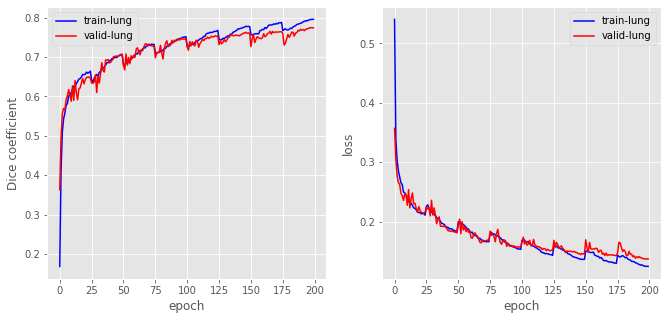

In [12]:
plt.style.use('ggplot')

fig, axes = plt.subplots(1, 2, figsize=(11,5))

axes[0].plot(infect_seg_res.history['dice'], color='b', label='train-lung')
axes[0].plot(infect_seg_res.history['val_dice'], color='r', label='valid-lung')
axes[0].set_ylabel('Dice coefficient')
axes[0].set_xlabel('epoch')
axes[0].legend()

axes[1].plot(infect_seg_res.history['loss'], color='b', label='train-lung')
axes[1].plot(infect_seg_res.history['val_loss'], color='r', label='valid-lung')
axes[1].set_ylabel('loss')
axes[1].set_xlabel('epoch')
axes[1].legend();

# 7. Saving Outputs

In [13]:
gc.collect()

with open('../outputs/infectseg-HistoryDict.cp', 'wb') as myfile:
    pickle.dump(infect_seg_res.history, myfile)

In [19]:
infect_seg.load_weights("../outputs/weights_infectseg.hdf5")

with tf.device('/cpu:0') :
    pred_infects = infect_seg.predict(ccts/255, batch_size=128)
    # pred_infects = tf.cast(pred_infects+0.5, dtype=tf.int32)
    
print(ccts.shape, clungs.shape, cinfects.shape, pred_infects.shape)

(4042, 128, 128, 1) (4042, 128, 128, 1) (4042, 128, 128, 1) (4042, 128, 128, 1)


# 8. Visualizing Outputs

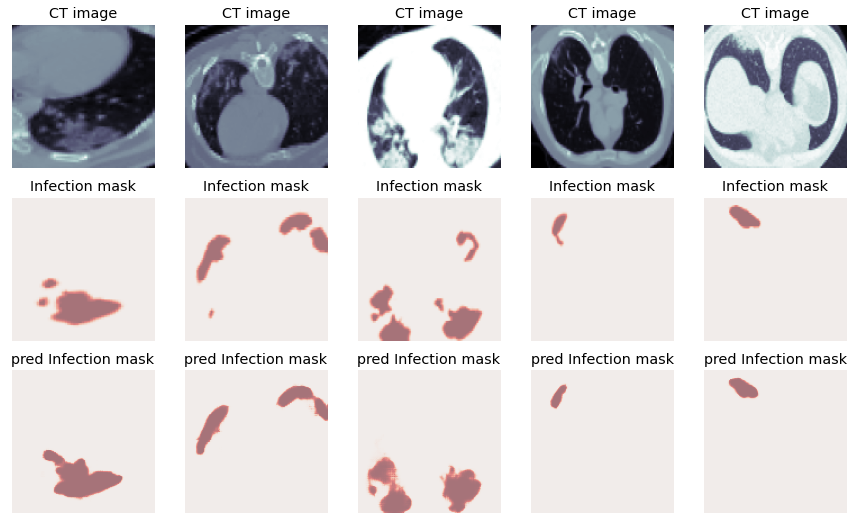

In [23]:
def plot_infect_seg(cct, infect, pred_infect, axes) :

    axes[0].imshow(cct[:,:,0], cmap='bone')
    axes[0].set_title('CT image'); plt.grid(None)
    axes[0].set_xticks([]); axes[0].set_yticks([])
    
    axes[1].imshow(infect[:,:,0], alpha=0.5, cmap='Reds')
    axes[1].set_title('Infection mask'); plt.grid(None)
    axes[1].set_xticks([]); axes[1].set_yticks([])

    axes[2].imshow(pred_infect[:,:,0], alpha=0.5, cmap='Reds')
    axes[2].set_title('pred Infection mask'); plt.grid(None)
    axes[2].set_xticks([]); axes[2].set_yticks([])
  

import random
indices = random.choices(range(len(pred_infects)), k=5)

fig, axes = plt.subplots(3, 5, figsize=(15,9))

for ii, idx in enumerate(indices) :
    plot_infect_seg(ccts[idx], cinfects[idx], pred_infects[idx], list(axes[:,ii]))